In this notebook, we use solubility data from the Therapeutic Data Commons (TDC) to build a model to predict the solubility of molecules from a recent publication by [Fang et al](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00160) from Biogen. 

In [2]:
from tdc.single_pred import ADME
from tqdm.auto import tqdm
from rdkit import Chem
import datamol as dm
from molfeat.trans import MoleculeTransformer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import useful_rdkit_utils as uru
import seaborn as sns
from rdkit.DataStructs import BulkTanimotoSimilarity
from scipy.stats import pearsonr
import scipy
from plot_regression import plot_regression

Read the Therapeutic Data Commons solubility data

In [3]:
tdc_data = ADME(name = 'Solubility_AqSolDB')

Found local copy...
Loading...
Done!


In [4]:
tdc_df = tdc_data.get_data()
tdc_df.head()

,Drug_ID,Drug,Y
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065


Change the column names to something more reasonable

In [5]:
tdc_df.columns = ["Name","SMILES","logS"]
tdc_df.head()

,Name,SMILES,logS
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065


Use [molfeat](https://molfeat.datamol.io) to calculate the RDKit 2D descriptors. 

In [6]:
with dm.without_rdkit_log():
    tdc_df['mol'] = tdc_df.SMILES.apply(Chem.MolFromSmiles)

A function to calculate the number of fragments in a molecule

In [7]:
def count_fragments(mol):
    frags = Chem.GetMolFrags(mol)
    return len(frags)

Calculate the number of fragments in each molecule in the TDC solubility dataset. 

In [8]:
tdc_df['num_frags'] = tdc_df.mol.apply(count_fragments)

Let's look at the distribution of the number of fragments. 

In [9]:
tdc_df.num_frags.value_counts()

1     8884
2      487
3      342
4       93
5       86
7       25
6       24
9       13
10       5
8        5
13       4
11       3
17       2
14       2
12       2
32       1
21       1
24       1
18       1
37       1
Name: num_frags, dtype: int64

What the heck!  There's a molecule in this set with 37 fragments.  I need to see what this is. 

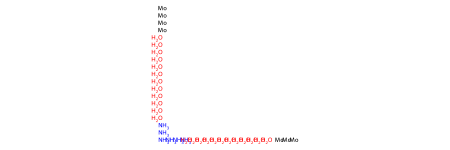

In [10]:
tdc_df.query("num_frags == 37").mol.values[0]

Allright, that's nonsense.  Let's get rid of anything with more than 1 fragment. 

In [11]:
tdc_df = tdc_df.query("num_frags == 1").copy()

Look at how many molecules are left. 

In [12]:
len(tdc_df)

8884

In [13]:
desc2D_transformer = MoleculeTransformer(featurizer="desc2D", dtype=float)

Calculate descriptors for the TDT set.  Note the use of **dm.without_rdkit_log**.  The desc2D transformer runs RDMolStandardizer, which is quite verbose.  I'd prefer to turn those messages off. 

In [14]:
with dm.without_rdkit_log():
    tdc_desc2D = desc2D_transformer(tdc_df.SMILES)

Add the descriptors to the dataframe.

In [28]:
tdc_df['desc2D'] = list(tdc_desc2D)

Let's see which molecules had descriptors with nans (not a number).  Note that this is weird stuff.  Let's get rid of it. 

In [30]:
tdc_df[np.isnan(tdc_desc2D).any(axis=1)]

,Name,SMILES,logS,mol,num_frags,dataset,desc2D
38,molybdenum,[Mo],-4.203848,<rdkit.Chem.rdchem.Mol object at 0x29853d6d0>,1,tdc,"[0.0, 0.0, 0.0, 0.0, 0.37204543852280225, 95.9..."
89,tungsten(4+) ion disulfanediide,S=[W]=S,-4.139134,<rdkit.Chem.rdchem.Mol object at 0x29859ad60>,1,tdc,"[0.0, 0.0, 0.0, 0.0, 0.5653718051787793, 247.9..."
116,"bis({[bis(3,5,5-trimethylhexyl)carbamothioyl]s...",CC(CCN(CCC(C)CC(C)(C)C)C(=S)S[Zn]SC(=S)N(CCC(C...,-6.102527,<rdkit.Chem.rdchem.Mol object at 0x2985a8970>,1,tdc,"[5.281088356638952, 0.0, 5.281088356638952, 0...."
132,dioxovanadium,O=[V]=O,-4.400250,<rdkit.Chem.rdchem.Mol object at 0x29853a0b0>,1,tdc,"[0.0, 0.0, 0.0, 0.0, 0.3628658125056348, 50.94..."
135,"({bis[(2-ethylhexanoyl)oxy]-2,4-dioxa-3-bora-1...",CCCCC(CC)C(=O)O[Co]OB(O[Co])O[Co](OC(=O)C(CC)C...,-1.825456,<rdkit.Chem.rdchem.Mol object at 0x29853a200>,1,tdc,"[10.325281557067271, -2.916666666666667, 10.32..."
...,...,...,...,...,...,...,...
5501,propagermanium,O=C(O)CC[Ge](=O)O[Ge](=O)CCC(=O)O,-1.493200,<rdkit.Chem.rdchem.Mol object at 0x2987152e0>,1,tdc,"[11.061274092970521, -3.202215608465609, 11.06..."
5553,"butanoic acid, 4,4'-diselenobis-",O=C(O)CCC[Se][Se]CCCC(=O)O,-2.247100,<rdkit.Chem.rdchem.Mol object at 0x297aac9e0>,1,tdc,"[10.15623503055186, -0.7229840741903331, 10.15..."
5654,"2,5-selenophenedicarboxylic acid, tetrahydro-",O=C(O)C1CCC(C(=O)O)[Se]1,-0.545000,<rdkit.Chem.rdchem.Mol object at 0x297a866d0>,1,tdc,"[10.392422052154195, -0.83912037037037, 10.392..."
6107,"o-diselenane-3,6-dicarboxylic acid, trans-(+)-",O=C(O)[C@H]1CC[C@H](C(=O)O)[Se][Se]1,-2.105300,<rdkit.Chem.rdchem.Mol object at 0x297aa8040>,1,tdc,"[10.509075018896448, -0.749339096749811, 10.50..."


Drop rows containing molecules with descriptors that are nan. 

In [31]:
tdc_df = tdc_df[~np.isnan(tdc_desc2D).any(axis=1)].copy()

Read the data from the the Fang et al paper. 

In [32]:
biogen_df = pd.read_csv("biogen_solubility.csv")

In [33]:
biogen_df.head()

,Internal ID,Vendor ID,SMILES,logS
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-5.548020
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-5.071409
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,-3.925969
3,Mol6,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,-4.535280
4,Mol9,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,-4.709963


Add an RDKit molecule column to the dataframe. 

In [34]:
biogen_df['mol'] = biogen_df.SMILES.apply(Chem.MolFromSmiles)

Calculate descriptors

In [35]:
with dm.without_rdkit_log():
    biogen_desc2D = desc2D_transformer(biogen_df.SMILES)

Add descriptors to the dataframe

In [36]:
biogen_df['desc2D'] = list(biogen_desc2D)

Check for nans in the descriptors.  This dataset looks good. 

In [37]:
biogen_df[np.isnan(biogen_desc2D).any(axis=1)]

,Internal ID,Vendor ID,SMILES,logS,mol,desc2D


Add a lablel to each molecule in both dataframes indicating which dataframe the molecule came from.  We'll use this for adversarial validation and plotting. 

In [38]:
biogen_df['dataset'] = 'biogen'
tdc_df['dataset'] = 'tdc'

Create a new dataframe by concatenating the two dataframes. 

In [39]:
cols = ['dataset','mol','desc2D']
adversarial_df = pd.concat([tdc_df[cols],biogen_df[cols]])

Add a Morgan Fingerprint column

In [40]:
adversarial_df['fp'] = adversarial_df.mol.apply(uru.mol2morgan_fp)

Calculate the similarity of each the molecules in the Biogen set to every molecule the TDC set.  Save the mean of the Tanimoto similarities to the 3 most similar molecules. 

In [41]:
sim_list = []
tdc_fp = adversarial_df.query("dataset == 'tdc'").fp.values.tolist()
biogen_fp = adversarial_df.query("dataset == 'biogen'").fp.values
for bg_fp in tqdm(biogen_fp):
    sim_list = BulkTanimotoSimilarity(bg_fp, tdc_fp)
    sim_list.append(np.mean(np.sort(sim_list)[-3:]))   

  0%|          | 0/2173 [00:00<?, ?it/s]

Plot the distribution of Tanimoto similarities

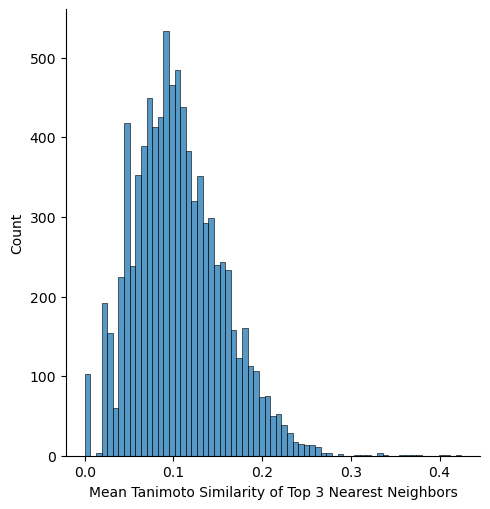

In [42]:
g = sns.displot(sim_list)
g.axes[0][0].set_xlabel("Mean Tanimoto Similarity of Top 3 Nearest Neighbors");

Calculate the first 50 principle components (PCs) of RDKit descriptors. 

In [43]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(np.stack(adversarial_df.desc2D))

Use TSNE to project the 50 PCs into 2 dimensions. 

In [44]:
tsne = TSNE(n_components=2)
tsne_crds = tsne.fit_transform(pcs)

Plot the TSNE coordinates coloring by dataset

<Axes: xlabel='tsne_x', ylabel='tsne_y'>

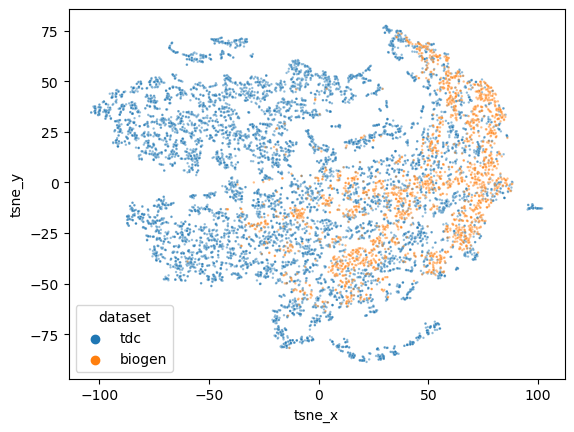

In [45]:
adversarial_df[["tsne_x","tsne_y"]] = tsne_crds
sns.scatterplot(x="tsne_x",y="tsne_y",data=adversarial_df,hue="dataset",s=3,alpha=0.5)

Convert the dataset labels to integers.  We need to do this build a classification model. 

In [46]:
le = LabelEncoder()
adversarial_df['label'] = le.fit_transform(adversarial_df.dataset)

### Adversarial Validation
Build a classification model that learns to distinguish BDC molecules from TDC molecules. 

In [47]:
auc_list = []
for i in tqdm(range(0,10)):
    train, test = train_test_split(adversarial_df)
    cls = LGBMClassifier()
    cls.fit(np.stack(train.desc2D), train.label)
    pred = cls.predict(np.stack(test.desc2D))
    auc = roc_auc_score(test.label, pred)
    auc_list.append(auc)

  0%|          | 0/10 [00:00<?, ?it/s]

Plot the ROC AuC values for the classification model

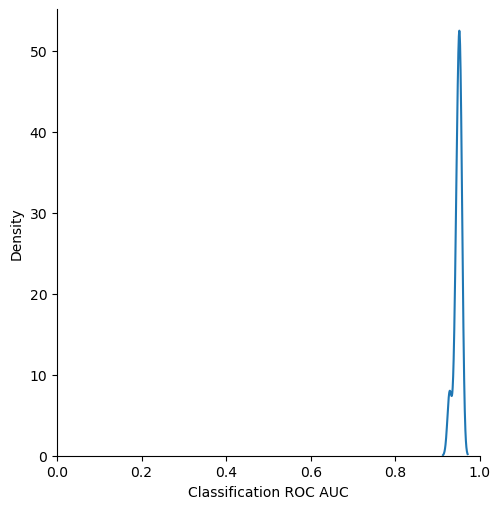

In [48]:
ax = sns.displot(auc_list,kind="kde")
ax.axes[0][0].set_xlim(0,1)
ax.axes[0][0].set_xlabel("Classification ROC AUC");

Use the descriptors from TDC data to build a regression model

In [49]:
regressor = LGBMRegressor()
regressor.fit(np.stack(tdc_df.desc2D),tdc_df.logS)

LGBMRegressor()

Use the regression model above to predict the solubility of the Biogen dataset. 

In [50]:
pred_logS = regressor.predict(np.stack(biogen_df.desc2D))
biogen_df['pred_logS'] = pred_logS

Plot the regression model results

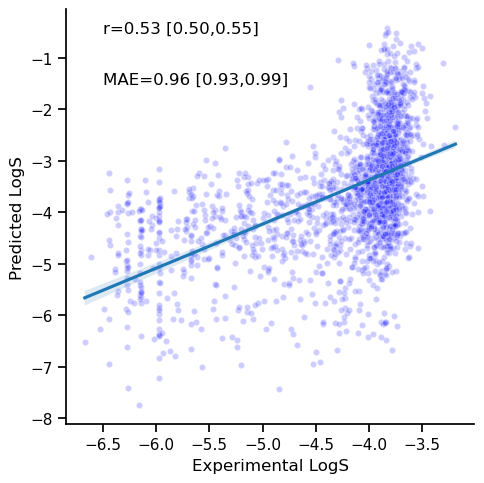

In [51]:
plot_regression(biogen_df.logS, biogen_df.pred_logS)